# Assignment 1

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures

**Authors**: Daniele Morotti, Andrea Sciamarelli, Andrea Valente

# Install and import dependencies

Load dependencies required

In [ ]:
# python packages
from dataclasses import dataclass
import itertools
import os
import os.path
import random
import re
import shutil
import typing
import urllib.request

# third-party packages
import keras
import keras.callbacks
import keras.layers
import keras.losses
import keras.optimizers
import keras.regularizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import tensorflow as tf
import tqdm

# Dataset

## Download the data

The dataset is downloaded, if not already present, and then unzipped at the specified path.

In [ ]:
@dataclass
class DatasetConfig:
    url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
    zip = os.path.join(os.getcwd(), "dependency_treebank.zip")
    folder = os.path.join(os.getcwd(), "dependency_treebank")


ds_config = DatasetConfig()

In [ ]:
def download_dataset(url: str, zip: str, folder: str) -> None:
    """Download and unzip the dataset from the url if not already downloaded
    Args:
        url (str): url of the dataset
        zip (str): zip name of the downloaded file
        folder (str): folder name contained in the zipped file
    """
    if not os.path.isdir(folder):
        if not os.path.isfile(zip):
            with urllib.request.urlopen(url) as res, open(zip, "wb") as f:
                print(f"Downloading from {url}")
                shutil.copyfileobj(res, f)
        else:
            print(f"Zip folder '{zip}' already present")
        shutil.unpack_archive(zip, extract_dir=folder)
        print(f"'{zip}' unzipped in {folder}")
    else:
        print(f"Folder '{folder}' already present")


download_dataset(ds_config.url, ds_config.zip, ds_config.folder)

'/content/dependency_treebank.zip' unzipped in /content/dependency_treebank


## Load the data in Pandas DataFrames

Read the data for training (1-100), validation (101-150) and test (151-199).

The function to process files has a parameter (*remove_punctuation*) to choose whether to remove punctuations or not. In the first case, the regex is applied on tags instead of texts, in this way the regex is simpler (many punctuations have the same tag).

We decided to split documents into sentences, in this way we can opt for shorter text tokenization (e.g. 64, or 128). This is beneficial for two reasons:

- The model is lighter, because the input is smaller when using sentences instead of documents. 
- Text lengths are more balanced and are closer to each other, instead with documents there is a wide difference. 

In [ ]:
class DataLoader:
    folder_name: str
    '''"(" and ")" are tagged with the following character
    sequences, respectively: "-RRB-" and "-LRB-"'''
    PUNCTUATIONS = r"(-RRB-)|(-LRB-)|[\.,\\\"'\-\?\:\!;\[\]\(\)\{\}⟨⟩‒–—―‐…\/⁄‘’“”`]+"

    def __init__(self, folder_name: str):
        self.folder_name = folder_name
        self.prog = re.compile(self.PUNCTUATIONS)

    def __call__(
        self,
        start_i: int,
        end_i: int,
        desc = None,
        remove_punctuation: bool = False,
        split_sentences: bool = True
    ) -> pd.DataFrame:
        """_summary_

        Args:
            start_file (int): Index of the first file to process
            end_file (int): Index of the last file to process
            dataset_description (str, optional): Dataset description to show while processing files. Defaults to None.
            remove_punctuation (bool, optional): if the process should remove all punctuations from each file. Defaults to False.
            split_sentences (bool, optional): if the process should split documents into sentences. Defaults to True

        Returns:
            pd.DataFrame: Dataframe containing the dataset, the first column contains texts, the second one contains tags
        """
        # the dataset dataframe, initially empty
        df = pd.DataFrame(columns=["text", "tags"])

        for i in tqdm.trange(start_i, end_i + 1, desc=f"Reading {desc} data"):
            # zeros contained in the filename
            idx_len = "0" * (4 - len(str(i)))
            # the filename is 'wsj_0xxx.dp'
            data_file = os.path.join(self.folder_name, self.folder_name.rsplit("/", maxsplit=1)[1], f"wsj_{idx_len}{i}.dp")
            # read the file, strip and split into a list of list (the inner one is for each text)
            with open(data_file, "r") as f:
                content = [l.strip().split() for l in f.readlines()]

            # lists of strings to keep track of sentences (occuring after each \n)
            Xrows, yrows = [""], [""]
            i = 0
            for c in content:
                """if the element is empty then it's a new line, so
                the following lines are considered as a new sentence"""
                if len(c) == 0:
                    if split_sentences:
                        i += 1
                        Xrows.append("")
                        yrows.append("")
                    continue

                assert len(c) == 3
                if remove_punctuation:
                    # the tag must not match the regex of punctuations
                    if self.prog.fullmatch(c[1]) is None:
                        Xrows[i] += (" " if len(Xrows[i]) > 0 else "") + c[0]
                        yrows[i] += (" " if len(yrows[i]) > 0 else "") + c[1]
                else:
                    Xrows[i] += (" " if len(Xrows[i]) > 0 else "") + c[0]
                    yrows[i] += (" " if len(yrows[i]) > 0 else "") + c[1]

            new_df = pd.DataFrame.from_dict({"text": Xrows, "tags": yrows})
            df = pd.concat([df, new_df], axis=0, ignore_index=True)
        return df


data_loader = DataLoader(ds_config.folder)
df_train = data_loader(1, 100, desc="train", split_sentences=True)
df_val = data_loader(101, 150, desc="validation", split_sentences=True)
df_test = data_loader(151, 199, desc="test", split_sentences=True)

Reading test data: 100%|██████████| 49/49 [00:00<00:00, 935.91it/s]


## Closer look at datasets

Each DataFrame has two columns, the first one contains sentences, while the second one tags. 

The data type of DataFrames is *string*.

All datasets contain 3914 sentences and 10947 unique words.

In [ ]:
def unique_words(ser: pd.Series) -> int:
    return np.unique(ser.str.lower().str.split(" ").agg(np.concatenate)).size

In [ ]:
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
print(f"All datasets sentences: {df_all['text'].count()}")
print(f"All datasets unique words: {unique_words(df_all['text'])}")

All datasets sentences: 3914
All datasets unique words: 10947


### Training set

It contains 1963 sentences and 7404 unique words.

In [ ]:
print(f"Sentences: {df_train['text'].count()}")
print(f"Unique words: {unique_words(df_train['text'])}")

Sentences: 1963
Unique words: 7404


In [ ]:
df_train.head()

,text,tags
0,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ..."
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN ."
2,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN..."
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...
4,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ..."


### Validation set

It contains 1299 sentences and 5420 unique words.

In [ ]:
print(f"Sentences: {df_val['text'].count()}")
print(f"Unique words: {unique_words(df_val['text'])}")

Sentences: 1299
Unique words: 5420


In [ ]:
df_val.head()

,text,tags
0,A House-Senate conference approved major porti...,DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD C...
1,"For the Agency for International Development ,...","IN DT NNP IN NNP NNP , NNS VBD $ CD CD IN JJ N..."
2,The conference approved at least $ 55 million ...,DT NN VBD IN JJS $ CD CD IN JJ NN CC NN NN IN ...
3,The agreement on Poland contrasts with the maj...,DT NN IN NNP VBZ IN DT JJ NNS VBG IN DT VBG JJ...
4,These fiscal pressures are also a factor in sh...,"DT JJ NNS VBP RB DT NN IN VBG DT NNP NN , CC I..."


### Test set

It contains 652 sentences and 3407 unique words.

In [ ]:
print(f"Sentences: {df_test['text'].count()}")
print(f"Unique words: {unique_words(df_test['text'])}")

Sentences: 652
Unique words: 3407


In [ ]:
df_test.head()

,text,tags
0,"Intelogic Trace Inc. , San Antonio , Texas , s...","NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD C..."
1,The move boosts Intelogic Chairman Asher Edelm...,DT NN VBZ NNP NNP NNP NNP POS NN TO CD NN IN C...
2,Mr. Ackerman already is seeking to oust Mr. Ed...,NNP NNP RB VBZ VBG TO VB NNP NNP IN NN IN NNP ...
3,The action followed by one day an Intelogic an...,DT NN VBN IN CD NN DT NNP NN IN PRP MD VB DT N...
4,In New York Stock Exchange composite trading y...,"IN NNP NNP NNP NNP JJ NN NN , NNP NNS VBD CD N..."


## Distribution of the tags

Overall, tags are pretty much balanced between datasets. In fact, the train set, which is the one with most sentences, has an higher frequency for most tags when compared to both validation and test sets.

The same can be said when comparing the validation set, which has more sentences, and the test set.

The training set contains all tags, however some are not present in the validation set (e.g. SYM) and the test set (LS). In our case that's not a problem because the network will still learn those tags which are helpful when generalizing, which is something we are of course interested.

If some words were missing in the training set then the network could not predict missing tags in any way.

In [ ]:
def count_tags_in_df(ser: pd.Series, name: str) -> pd.DataFrame:
    """ Count the number of occurences for each tag in the Series.

    Args:
        ser (pd.Series): pandas Series containing tag strings
        name (str): dataset name from which tags belong

    Returns:
        pd.DataFrame: DataFrame of the frequency for each tag
    """    
    d_tags = {}

    # split each sentence of tags into a list of strings
    for tags in ser.str.split(" "):
        for tag in tags:
            # count of the tag is incremented by 1
            d_tags[tag] = d_tags.get(tag, 0) + 1
    return pd.DataFrame.from_records(
        list(d_tags.items()), columns=["tags", f"{name}_counts"]
    )


tags_train = count_tags_in_df(df_train.tags, "train")
tags_val = count_tags_in_df(df_val.tags, "validation")
tags_test = count_tags_in_df(df_test.tags, "test")

Compare tags distribution between datasets.

In [ ]:
tags_all = (
    tags_train.merge(tags_val, how="outer", on="tags")
    .merge(tags_test, how="outer", on="tags", sort=True)
    .fillna(0)
    .convert_dtypes(convert_integer=True)
)

display(tags_all)

,tags,train_counts,validation_counts,test_counts
0,#,1,15,0
1,$,342,173,209
2,'',399,225,70
3,",",2571,1528,787
4,-LRB-,52,50,18
5,-RRB-,55,53,18
6,.,1959,1277,638
7,:,293,214,56
8,CC,1141,758,366
9,CD,1439,1249,858


Some tags have an higher frequency than others, for obvious reasons. For example NN, which stands for Noun Singular, are more used than -LRB- (left bracket), which are more rare in sentences.

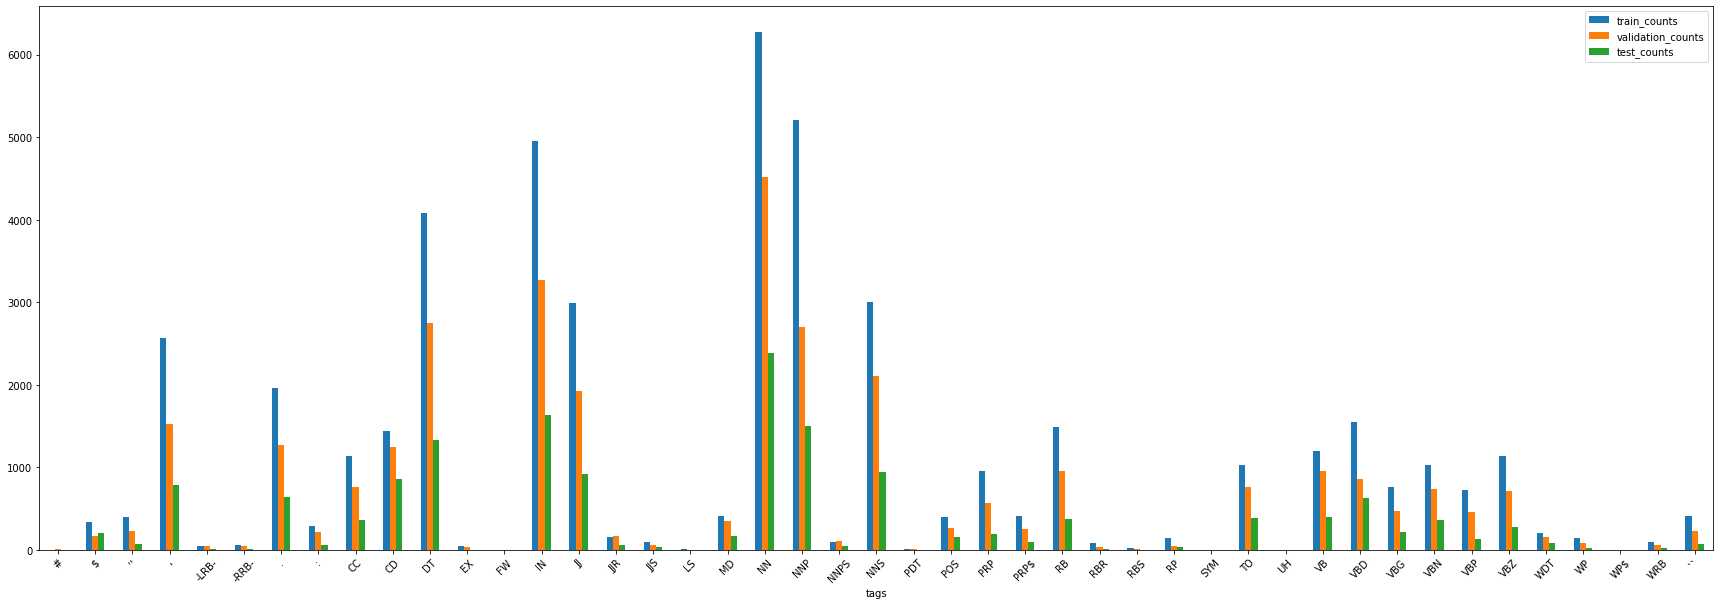

In [ ]:
tags_all.plot.bar("tags", rot=45, figsize=(30, 10))
plt.show()

## Difference between sentence and document lengths

As stated before, we decided to split each text at sentence level, instead of document's. The explanation is clear from the plot showed in the current section: the maximum length for tokenization is smaller.

The highest possible length at sentence-level, which covers all samples, even outliers, is smaller than the minimum length possible with documents, which is 512 tokens (most popular length in **Transformers**). Besides, the latter doesn't even cover half of documents available for training, hence the text would be split for most samples.

Furthermore, documents aren't much relevant for this task; our goal is to classify each word's tag, so as long as the entire sentence is covered by the tokenization then tags are going to be predicted without losing too much context.

Moving forward, the specific maximum length should cover almost all data. In this case, with the red dotted line are shown four different choices: 64, 96, 128, 256. The last one is the only one covering all data among datasets available, but it is way larger than what is needed for our use cases. In addition, a longer maximum length may results in a more difficult model to train, which at the end requires more computational power.

At the end, we decided for the best trade-off between learning capabilities and model size: 96 tokens. The benefit of this choice is that all sentences in validation and test datasets are perfectly tokenized, hence our evaluations cover all possible tags available for each sentence, without the need to tokenize using other techniques, such as applying **sliding window** across inputs.

In [ ]:
def plot_length_boxplot(dfs: typing.Dict[str, pd.DataFrame], examples: typing.List[int], split_type: str):
    fig, axs = plt.subplots(1, len(dfs.keys()), figsize=(15, 6), sharey=True)
    faxs = axs.ravel()

    fig.suptitle(f"Split at {split_type} level", fontsize=16)

    for max_seq, fax in itertools.product(examples, faxs):
        fax.axhline(max_seq, color="red", label=f"{max_seq}", linestyle="--")

    for i, (name, df) in enumerate(dfs.items()):
        df["tags"].apply(lambda x: len(x.split(" "))).plot.box(
            ax=faxs[i], title=f"{name.title()}"
        )
        faxs[i].legend()

    fig.show()

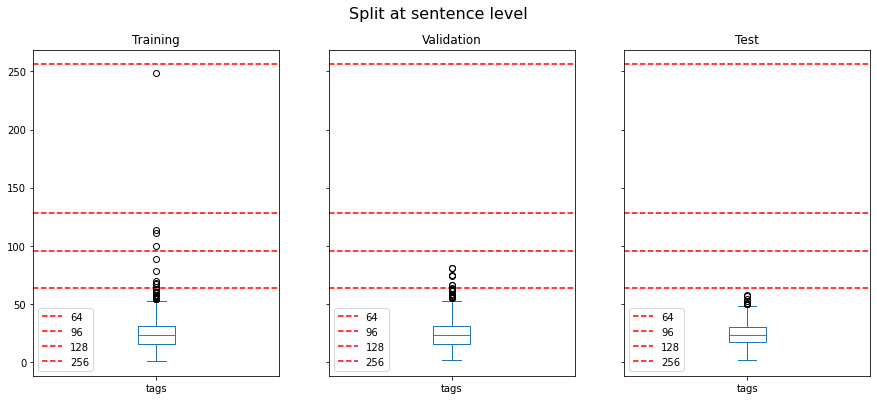

In [ ]:
plot_length_boxplot({"training": df_train, "validation": df_val, "test": df_test}, [64, 96, 128, 256], "sentence")

Reading test data: 100%|██████████| 49/49 [00:00<00:00, 346.81it/s]


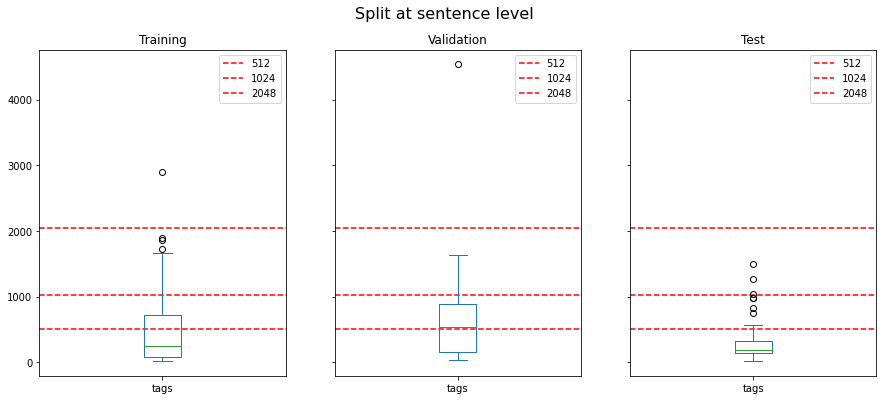

In [ ]:
df_train_docs = data_loader(1, 100, desc="train", split_sentences=False)
df_val_docs = data_loader(101, 150, desc="validation", split_sentences=False)
df_test_docs = data_loader(151, 199, desc="test", split_sentences=False)

plot_length_boxplot(
    {"training": df_train_docs, "validation": df_val_docs, "test": df_test_docs}, 
    [512, 1024, 2048], 
    "sentence"
)

# Model preparation

The *model configuration* will be used in the following sections.

It includes the embedding dimension, the maximum sequence length, the vocabulary size, the number of epochs for each model and some regularization parameters (dropout rates and L2 regularizer).

In [ ]:
@dataclass
class ModelConfiguration:
    EMBEDDING_DIM = 300
    MAX_SEQUENCE = 96
    VOCABULARY_SIZE = 15000
    EPOCHS = 70

model_conf = ModelConfiguration()

## Dataframe to dataset

The concatenation of all dataframes are converted to a Tensorflow Dataset.

In [ ]:
def df_to_dataset(df: pd.DataFrame, batch_size: int = 32) -> tf.data.Dataset:
    """Convert a dataframe to a Tensorflow Dataset.

    Args:
        df (pd.DataFrame): DataFrame to convert
        batch_size (int, optional): batch size of the dataset. Defaults to 32.

    Returns:
        tf.data.Dataset: converted Tensorflow Dataset
    """
    return tf.data.Dataset.from_tensor_slices((df["text"], df["tags"])).batch(
        batch_size
    )


raw_all_ds = df_to_dataset(pd.concat([df_train, df_val, df_test], ignore_index=True), 512)

## Tokenization and encoding

### Tokenization

Tokenization is applied using the Keras Text Vectorization layer. Mandatory parameters are the dataset, the vocabulary size and the maximum length of the tokenized sequence. 

The vocabulary is built on top of the dataset, but the size is limited to the one specified. The given dataset is already cleaned, therefore the only preprocessing applied by the layer is the transformation of words in lowercase. Finally, words are tokenized in integers.

The vocabulary size is chosen as slightly higher than the maximum number of unique words (10947). In this specific application, keeping in mind the task goal and available data, the tokenization vocabulary covers all dataset words, even in validation and in test. The vocabulary size has two additional tokens: UNK words and the empty string (padding is applied on datasets).

We are aware in many cases, with more data or in a completely different task, our choice is not suitable, for a few things:
- A larger model size lead to a more computational cost for training.
- Benefits in the learning capability from rare words are limited.

In [ ]:
class TokenizeFeatures:
    vocab_size: int
    max_sequence: int
    layer: keras.layers.TextVectorization

    def __init__(
        self, dataset: tf.data.Dataset, vocab_size: int = 50000, max_sequence: int = 64
    ):
        self.vocab_size = vocab_size
        self.max_sequence = max_sequence

        self.layer = keras.layers.TextVectorization(
            max_tokens=self.vocab_size,
            output_mode="int",
            standardize="lower",
            output_sequence_length=self.max_sequence,
        )

        features_ds = dataset.map(lambda x, _: x)
        features_ds = features_ds.map(
            lambda x: tf.strings.split(x, sep=" ").to_tensor()
        )
        features_ds = features_ds.map(lambda x: tf.expand_dims(x, -1))

        self.layer.adapt(features_ds)

    def __call__(self, dataset: tf.data.Dataset) -> tf.data.Dataset:
        """Convert the text into tokens

        Args:
            dataset (tf.data.Dataset): dataset

        Returns:
            tf.data.Dataset: dataset with text tokenized
        """
        return dataset.map(lambda x, y: (self.layer(x), y))

    def get_vocabulary(self) -> typing.List[str]:
        """Return the vocabulary used by the tokenization layer

        Returns:
            typing.List[str]: vocabulary
        """
        return self.layer.get_vocabulary()


tokenize_features = TokenizeFeatures(
    raw_all_ds, model_conf.VOCABULARY_SIZE, model_conf.MAX_SEQUENCE
)

### Encode of labels

Encoding of tags is performed by the Keras String Lookup layer. Parameters are the dataset and the maximum length of the encoded sequence. The latter value is the same one used in the tokenization layer because the output of the network has the same length as the input because this task is performed at word level.

Our strategy is to encode tags in integers instead of other outputs, such as one-hot encoding.

In [ ]:
class EncodeLabels:
    max_sequence: int
    layer: keras.layers.StringLookup

    def __init__(self, dataset: tf.data.Dataset, max_sequence: int = 50000):
        self.max_sequence = max_sequence
        self.layer = keras.layers.StringLookup(output_mode="int")

        label_ds = dataset.map(lambda _, y: y)
        label_ds = label_ds.map(lambda y: tf.strings.split(y, sep=" ").to_tensor())
        label_ds = label_ds.map(lambda y: y[..., : self.max_sequence])
        label_ds = label_ds.map(lambda y: self.padding_sequence(y))

        self.layer.adapt(label_ds)

    def padding_sequence(self, y):
        return tf.concat([y, tf.fill((tf.shape(y)[0], self.max_sequence - tf.shape(y)[-1]), "")], -1)

    def __call__(self, dataset: tf.data.Dataset) -> tf.data.Dataset:
        """Encode labels in integer representation

        Args:
            dataset (tf.data.Dataset): dataset

        Returns:
            tf.data.Dataset: dataset with labels encoded
        """
        ds = dataset.map(lambda x, y: (x, tf.strings.split(y, sep=" ").to_tensor()))
        ds = ds.map(lambda x, y: (x, y[..., : self.max_sequence]))
        ds = ds.map(lambda x, y: (x, self.padding_sequence(y)))
        ds = ds.map(lambda x, y: (x, self.layer(y)))
        return ds

    def get_vocabulary(self) -> typing.List[str]:
        """Return the vocabulary used by the encoding layer

        Returns:
            typing.List[str]: vocabulary
        """
        return self.layer.get_vocabulary()

    def get_vocabulary_size(self) -> int:
        """Return the vocabulary size

        Returns:
            int: vocabulary size
        """
        return self.layer.vocabulary_size()


encode_labels = EncodeLabels(raw_all_ds, model_conf.MAX_SEQUENCE)

### Decode of labels

This layer is used after inference to decode integers to tags. It uses the same Keras layer for encoding, but the layer is initialized with the same encoding vocabulary. To perform the decoding operation, the *invert* parameter is set: the layer maps indices to vocabulary items.

The class instance can be used both when the input is an array of integers or an array of predictions, in the case of the model output.

In [ ]:
class DecodeLabels:
    layer: keras.layers.StringLookup

    def __init__(self, vocabulary: typing.List[str]):
        self.layer = keras.layers.StringLookup(
            output_mode="int", vocabulary=vocabulary, invert=True
        )

    def __call__(self, ds: np.ndarray, predict=True) -> np.ndarray:
        """_summary_

        Args:
            ds (np.ndarray): _description_
            predict (bool, optional): _description_. Defaults to True.

        Returns:
            np.ndarray: _description_
        """        
        if predict:
            ds = tf.math.argmax(ds, axis=-1)
        ds = self.layer(ds).numpy()
        # ds = tf.strings.reduce_join(ds, axis=-1, separator=" ")
        # ds = tf.strings.strip(ds)
        return ds.astype(str)


decode_labels = DecodeLabels(encode_labels.get_vocabulary())

## Encode and tokenize datasets

Each DataFrame is converted to a TensorFlow Dataset, then the tokenization of sentences and the encode of tags is performed.

In [ ]:
def prepare_data(df: pd.DataFrame, batch_size: int) -> tf.data.Dataset:
    """_summary_

    Args:
        df (pd.DataFrame): input Dataframe
        batch_size (int): batch size of the Dataset

    Returns:
        tf.data.Dataset: tokenized and encoded Dataset
    """    
    ds = df_to_dataset(df, batch_size)
    ds = encode_labels(ds)
    return tokenize_features(ds).prefetch(tf.data.AUTOTUNE)


train_ds = prepare_data(df_train, 64)
val_ds = prepare_data(df_val, 512)
test_ds = prepare_data(df_test, 512)

## Embedding layer

The GloVE embedding is used. In particular the one downloaded comes from *Wikipedia 2014 + Gigaword 5* with 400K words.

Word weights are available in different dimensions (50d, 100d, 200d and 300d), the one used in this notebook is the highest possible: 300d.

In [ ]:
@dataclass
class EmbeddingConfig:
    url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip"
    zip = os.path.join(os.getcwd(), "glove.6B.zip")
    folder = os.path.join(os.getcwd(), "glove.6B")


embd_config = EmbeddingConfig()

download_dataset(embd_config.url, embd_config.zip, embd_config.folder)

'/content/glove.6B.zip' unzipped in /content/glove.6B


### Get GloVe vocabulary

In [ ]:
def load_glove_embedding(glove_file: str) -> typing.Dict[str, np.ndarray]:
    """Read the GloVE file and split each word with corresponding weights.

    Args:
        glove_file (str): GloVE path

    Returns:
        typing.Dict[str, np.ndarray]: dictionary of words weights
    """    
    embeddings_index = {}

    with open(glove_file, encoding="utf-8") as f:
        file_content = f.readlines()

    for line in tqdm.tqdm(file_content, desc=f"Loading GloVe"):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=float, sep=" ")
        embeddings_index[word] = coefs
    return embeddings_index


glove_file = os.path.join(embd_config.folder, f"glove.6B.{model_conf.EMBEDDING_DIM}d.txt")
embeddings_index = load_glove_embedding(glove_file)

print(f"\nFound {len(embeddings_index)} word vectors.")

Loading GloVe: 100%|██████████| 400001/400001 [00:17<00:00, 22350.79it/s]



Found 400001 word vectors.


### Handling of OOV terms

Words in datasets not available in the GloVe vocabulary must have some embedding weights as well, otherwise the learning capabilities of our model are limited.

We set random weights for out of vocabulary (OOV) words instead of setting them to zero, in this way the model could still learn from the data, whereas setting them to zero limits the model.

In general, the embedding vocabulary of OOV words is built in an incremental way:
- The training embedding uses only the GloVE vocabulary and the OOV words in the training dataset.
- The validation embedding uses the training embedding and the OOV words in the validation dataset.
- The test embedding uses the validation embedding and the OOV words in the test dataset.

Therefore, the input of the model is `Input((MAX_SEQUENCE, EMBEDDING_DIM), dtype="int64")`, a batch of size (SENTENCES, MAX_SEQUENCE, EMBEDDING_DIMENSION).

However, to improve performances in both training and inference we decided to use the Keras Embedding layer, initialized with the embedding vocabulary of all datasets, the *test embedding* of the previous example. 

The Embedding layer benefits from GPU performance when placed inside the model, otherwise the embedding matrix is placed in the CPU memory. 

The input of the model is limited to `Input((MAX_SEQUENCE), dtype="int64")`, a batch of size (SENTENCES, MAX_SEQUENCE).

In [ ]:
def set_reproducibility(seed: int) -> np.random.Generator:
    """Set seed for reproducibility

    Args:
        seed (int): seed

    Returns:
        np.random.Generator: numpy Generator to use in functions
    """
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    return np.random.default_rng(seed)


rng = set_reproducibility(42)

In [ ]:
def load_model_embedding(
    vocabulary: typing.List[str],
    embeddings_index: typing.Dict[str, np.ndarray],
    embedding_dim: int,
    rng: typing.Optional[np.random.Generator]
) -> np.ndarray:
    """_summary_

    Args:
        vocabulary (typing.List[str]): List of words. Could be the vocabulary for tokenization
        embeddings_index (typing.Dict[str, np.ndarray]): Dictionary of word weights
        embedding_dim (int): Embedding dimension
        rng (np.random.Generator): Numpy generator for random values. Optional

    Returns:
        np.ndarray: matrix of embedding of vocabulary words and embedding weights
    """
    if rng is None:
        rng = np.random.default_rng()

    embedding_matrix = np.zeros((len(vocabulary), embedding_dim))

    for i, word in enumerate(vocabulary):
        """If the embedding can be found on V1, we take that, otherwise
        it's an OOV word and therefore we randomly generate an embedding for it"""
        embedding_vector = embeddings_index.get(word, rng.random((embedding_dim,)))
        assert embedding_vector.size == embedding_dim
        embedding_matrix[i] = embedding_vector
    return embedding_matrix


embedding_matrix = load_model_embedding(
    tokenize_features.get_vocabulary(), embeddings_index, model_conf.EMBEDDING_DIM, rng
)
print(f"Converted {embedding_matrix.shape[0]} words")

Converted 10949 words


# Models

Four different models have been trained on the same task. The baseline is the one we want to improve by tuning some parameters and adding/changing some layers.

All models are different Recurrent Neural Network: most of them have LSTM layers, while only one has a GRU layer.

The number of tags is the last shape of the model output: the length of the encoding vocabulary used for labels, equals to 47.

Except for the baseline model, which we want to keep as plain as possible in order to do better comparative analysis, others have regularization layers (SpatialDropout and Dropout) and L2 penalty regularization. 

Even though each model has been tuned differently for the same regularization layer, the choice has been mostly intuitive: one model is more lightweight then another (e.g. GRU network), hence regularizations can be softer, while for more complex models (e.g. Dual BiLSTM) regularizations are more necessary. However, we are not interested in the perfect score, we just wanted to show how some models, if tuned and regularized, can achieve better performance even with less parameters. This is the case for the GRU model, with the best overall performance.

The Keras Model Checkpoint callback is used in each model to retrieve the best weights during training. The reference for the best model is the validation loss.

In [ ]:
NUM_CLASSES = encode_labels.get_vocabulary_size()
print(f"Number of tag classes is: {NUM_CLASSES}")

histories = dict()

Number of tag classes is: 47


In [ ]:
!rm df_model_no_punct.pkl
!rm df_model_punct.pkl

## Baseline model

The baseline model has only 4 layers:
- Input.
- Embedding layer initialized with the Embedding vocabulary of all datasets.
- Bidirectional LSTM layer of 128 units.
- Dense layer with a softmax activation function for categorical classification of tags.

Trainable parameters are 451,375 and the model is run for 70 epochs with a batch size of 32.

The model stops improving after 44 epochs, thus the best model is loaded from this epoch.

In [ ]:
def create_baseline_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    lstm = keras.layers.LSTM(128, return_sequences=True)
    x = keras.layers.Bidirectional(lstm)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


baseline_model = create_baseline_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
baseline_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 96, 300)           3284700   
                                                                 
 bidirectional_3 (Bidirectio  (None, 96, 256)          439296    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 96, 47)            12079     
                                                                 
Total params: 3,736,075
Trainable params: 451,375
Non-trainable params: 3,284,700
_________________________________________________________________


In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("./baseline/", save_best_only=True, save_weights_only=True, verbose=1, mode="min", monitor="val_loss", initial_value_threshold=0.09)
histories["baseline"] = baseline_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS, callbacks=[model_checkpoint])

baseline_model.load_weights("baseline/")

Epoch 1/70
28/31 [==========================>...] - ETA: 0s - loss: 0.9855 - accuracy: 0.7550
Epoch 1: val_loss did not improve from 0.09000
31/31 [==============================] - 4s 46ms/step - loss: 0.9675 - accuracy: 0.7602 - val_loss: 0.7140 - val_accuracy: 0.8288
Epoch 2/70
28/31 [==========================>...] - ETA: 0s - loss: 0.6402 - accuracy: 0.8440
Epoch 2: val_loss did not improve from 0.09000
31/31 [==============================] - 1s 20ms/step - loss: 0.6373 - accuracy: 0.8450 - val_loss: 0.5674 - val_accuracy: 0.8618
Epoch 3/70
28/31 [==========================>...] - ETA: 0s - loss: 0.4955 - accuracy: 0.8770
Epoch 3: val_loss did not improve from 0.09000
31/31 [==============================] - 1s 20ms/step - loss: 0.4910 - accuracy: 0.8783 - val_loss: 0.4274 - val_accuracy: 0.8899
Epoch 4/70
31/31 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.9071
Epoch 4: val_loss did not improve from 0.09000
31/31 [==============================] - 1s 20

## Model with a Gated Recurrent Units (GRU) Layer

The GRU model has 6 layers:
- Input.
- Embedding layer initialized with the Embedding vocabulary of all datasets.
- Spatial dropout layer with a rate of 0.1. It drops the entire weights of some tokens. 
- Bidirectional GRU layer of 128 units with L2 regularizer penalty, sets to 0.001, applied to the recurrent kernel weights matrix.
- Dropout layer sets to 0.1 rate. It drops some unit nodes.
- Dense layer with a softmax activation function for categorical classification of tags.

Trainable parameters are 342,319 and the model is run for 70 epochs.

The model has fewer parameters compared to the baseline with better performance.

Without regularizations, the model overfits after 39 epochs, slightly less than the baseline model. The reason is that the GRU layer is less powerful and has fewer units than the LSTM layer.

In [ ]:
def create_gru_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    x = keras.layers.SpatialDropout1D(0.1)(x)

    gru = keras.layers.GRU(128, return_sequences=True, recurrent_regularizer=keras.regularizers.l2(0.001))
    x = keras.layers.Bidirectional(gru)(x)

    x = keras.layers.Dropout(0.1)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


gru_model = create_gru_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
gru_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 96)]              0         
                                                                 
 embedding_17 (Embedding)    (None, 96, 300)           3284700   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 96, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_17 (Bidirecti  (None, 96, 256)          330240    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 96, 256)           0         
                                                                 
 dense_17 (Dense)            (None, 96, 47)            120

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("./gru/", save_best_only=True, save_weights_only=True, verbose=1, mode="min", monitor="val_loss", initial_value_threshold=0.08)
histories["gru"] = gru_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS, callbacks=[model_checkpoint])

gru_model.load_weights("gru/")

Epoch 1/70
28/31 [==========================>...] - ETA: 0s - loss: 1.2330 - accuracy: 0.7639
Epoch 1: val_loss did not improve from 0.08000
31/31 [==============================] - 4s 43ms/step - loss: 1.2044 - accuracy: 0.7691 - val_loss: 0.8287 - val_accuracy: 0.8422
Epoch 2/70
29/31 [===========================>..] - ETA: 0s - loss: 0.7155 - accuracy: 0.8614
Epoch 2: val_loss did not improve from 0.08000
31/31 [==============================] - 1s 25ms/step - loss: 0.7088 - accuracy: 0.8627 - val_loss: 0.5893 - val_accuracy: 0.8834
Epoch 3/70
28/31 [==========================>...] - ETA: 0s - loss: 0.5144 - accuracy: 0.8960
Epoch 3: val_loss did not improve from 0.08000
31/31 [==============================] - 1s 19ms/step - loss: 0.5088 - accuracy: 0.8975 - val_loss: 0.4345 - val_accuracy: 0.9140
Epoch 4/70
28/31 [==========================>...] - ETA: 0s - loss: 0.3904 - accuracy: 0.9217
Epoch 4: val_loss did not improve from 0.08000
31/31 [==============================] - 1s 19

## Model with two Bidirectional Long Short-Term Memory (LSTM) Layers

The Dual BiLSTM model has 6 layers:
- Input.
- Embedding layer initialized with the Embedding vocabulary of all datasets.
- Spatial dropout layer with a rate of 0.2. It drops the entire weights of some tokens. 
- Bidirectional LSTM layer of 128 units with L2 regularizer penalty, sets to 0.02, applied to the recurrent kernel weights matrix.
- Dropout layer sets to 0.3 rate. It drops some unit nodes.
- Bidirectional LSTM layer of 128 units with L2 regularizer penalty, sets to 0.02, applied to the recurrent kernel weights matrix.
- Dropout layer sets to 0.3 rate. It drops some unit nodes.
- Dense layer with a softmax activation function for categorical classification of tags.

Trainable parameters are 845,615 and the model is run for 70 epochs.

The model has doubled its parameters compared to the baseline but achieves better performance.

Without regularizations, the model overfits after 38 epochs, slightly less than the baseline model.

Regularizations are more powerful in this model compared to the GRU model, in fact the chosen rates are set to 0.3 and the L2 regularizer penalty is set to 0.02. This is needed because the risk of overfitting with a small set of data but a more powerful model are higher. In this way the model can achieve the same performance as the GRU model, which means that a simpler network is better with less data.

In [ ]:
def create_dual_lstm_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    x = keras.layers.SpatialDropout1D(0.2)(x)

    for _ in range(2):
        lstm = keras.layers.LSTM(128, return_sequences=True, recurrent_regularizer=keras.regularizers.l2(0.02))
        x = keras.layers.Bidirectional(lstm)(x)
        x = keras.layers.Dropout(0.3)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


dual_lstm_model = create_dual_lstm_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
dual_lstm_model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 96)]              0         
                                                                 
 embedding_40 (Embedding)    (None, 96, 300)           3284700   
                                                                 
 spatial_dropout1d_23 (Spati  (None, 96, 300)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_62 (Bidirecti  (None, 96, 256)          439296    
 onal)                                                           
                                                                 
 dropout_51 (Dropout)        (None, 96, 256)           0         
                                                                 
 bidirectional_63 (Bidirecti  (None, 96, 256)          394

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("./duallstm/", save_best_only=True, save_weights_only=True, verbose=1, mode="min", monitor="val_loss", initial_value_threshold=0.08)
histories["dual_lstm"] = dual_lstm_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS, callbacks=[model_checkpoint])

dual_lstm_model.load_weights("duallstm/")

Epoch 1/70
31/31 [==============================] - ETA: 0s - loss: 7.6148 - accuracy: 0.7510
Epoch 1: val_loss did not improve from 0.08000
31/31 [==============================] - 11s 101ms/step - loss: 7.6148 - accuracy: 0.7510 - val_loss: 4.2564 - val_accuracy: 0.7957
Epoch 2/70
30/31 [============================>.] - ETA: 0s - loss: 2.8862 - accuracy: 0.7955
Epoch 2: val_loss did not improve from 0.08000
31/31 [==============================] - 2s 49ms/step - loss: 2.8619 - accuracy: 0.7963 - val_loss: 1.8079 - val_accuracy: 0.8044
Epoch 3/70
31/31 [==============================] - ETA: 0s - loss: 1.3565 - accuracy: 0.8093
Epoch 3: val_loss did not improve from 0.08000
31/31 [==============================] - 1s 44ms/step - loss: 1.3565 - accuracy: 0.8093 - val_loss: 0.9847 - val_accuracy: 0.8302
Epoch 4/70
30/31 [============================>.] - ETA: 0s - loss: 0.8242 - accuracy: 0.8330
Epoch 4: val_loss did not improve from 0.08000
31/31 [==============================] - 1s 

## Model with an additional Dense Layer

The Dual Dense model has 6 layers:
- Input.
- Embedding layer initialized with the Embedding vocabulary of all datasets.
- Spatial dropout layer with a rate of 0.1. It drops the entire weights of some tokens. 
- Bidirectional LSTM layer of 128 units with L2 regularizer penalty, sets to 0.01, applied to the recurrent kernel weights matrix.
- Dropout layer sets to 0.1 rate. It drops some unit nodes.
- Time distributed dense layer.
- Dense layer with a softmax activation function for categorical classification of tags.

Trainable parameters are 453,631 and the model is run for 70 epochs.

The model has slightly more parameters than the baseline but achieve better performance.

Regularizations are more powerful in this model compared to the GRU model, but are more balanced with respect to the Dual BiLSTM model. The chosen rates are set to 0.1 and the L2 regularizer penalty is set to 0.01. There is still a risk of overfitting, but the additional Dense layer helps for achieving better performance compared to other models.

In [ ]:
def create_dual_dense_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    x = keras.layers.SpatialDropout1D(0.1)(x)
    
    lstm = keras.layers.LSTM(128, return_sequences=True, recurrent_regularizer=keras.regularizers.l2(0.01))
    x = keras.layers.Bidirectional(lstm)(x)
    x = keras.layers.Dropout(0.1)(x)

    x = keras.layers.TimeDistributed(keras.layers.Dense(num_classes, activation="relu"))(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


dual_dense_model = create_dual_dense_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
dual_dense_model.summary()

Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 96)]              0         
                                                                 
 embedding_44 (Embedding)    (None, 96, 300)           3284700   
                                                                 
 spatial_dropout1d_27 (Spati  (None, 96, 300)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_67 (Bidirecti  (None, 96, 256)          439296    
 onal)                                                           
                                                                 
 dropout_56 (Dropout)        (None, 96, 256)           0         
                                                                 
 time_distributed_3 (TimeDis  (None, 96, 47)           120

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("./dualdense/", save_best_only=True, save_weights_only=True, verbose=1, mode="min", monitor="val_loss", initial_value_threshold=0.08)
histories["dual_dense"] = dual_dense_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS, callbacks=[model_checkpoint])

dual_dense_model.load_weights("dualdense/")

Epoch 1/70
30/31 [============================>.] - ETA: 0s - loss: 2.8821 - accuracy: 0.7448
Epoch 1: val_loss did not improve from 0.08000
31/31 [==============================] - 4s 50ms/step - loss: 2.8567 - accuracy: 0.7464 - val_loss: 1.7645 - val_accuracy: 0.7968
Epoch 2/70
29/31 [===========================>..] - ETA: 0s - loss: 1.3465 - accuracy: 0.8169
Epoch 2: val_loss did not improve from 0.08000
31/31 [==============================] - 1s 24ms/step - loss: 1.3276 - accuracy: 0.8182 - val_loss: 0.9805 - val_accuracy: 0.8411
Epoch 3/70
30/31 [============================>.] - ETA: 0s - loss: 0.8009 - accuracy: 0.8518
Epoch 3: val_loss did not improve from 0.08000
31/31 [==============================] - 1s 21ms/step - loss: 0.7962 - accuracy: 0.8526 - val_loss: 0.6351 - val_accuracy: 0.8737
Epoch 4/70
31/31 [==============================] - ETA: 0s - loss: 0.5415 - accuracy: 0.8823
Epoch 4: val_loss did not improve from 0.08000
31/31 [==============================] - 1s 21

# Evaluation

## Training trend analysis

Let's see how the training of networks went. 

This is useful in order to determine whether the networks overfitted or not. We could have potentially set up a so-called "callback" and, in particular, an "EarlyStopping" callback, to make sure that the training stops as soon as the chosen metric stops improving (up to a certain tolerance) for a certain number of epochs, but training on this small dataset does not take a lot of time anyway.

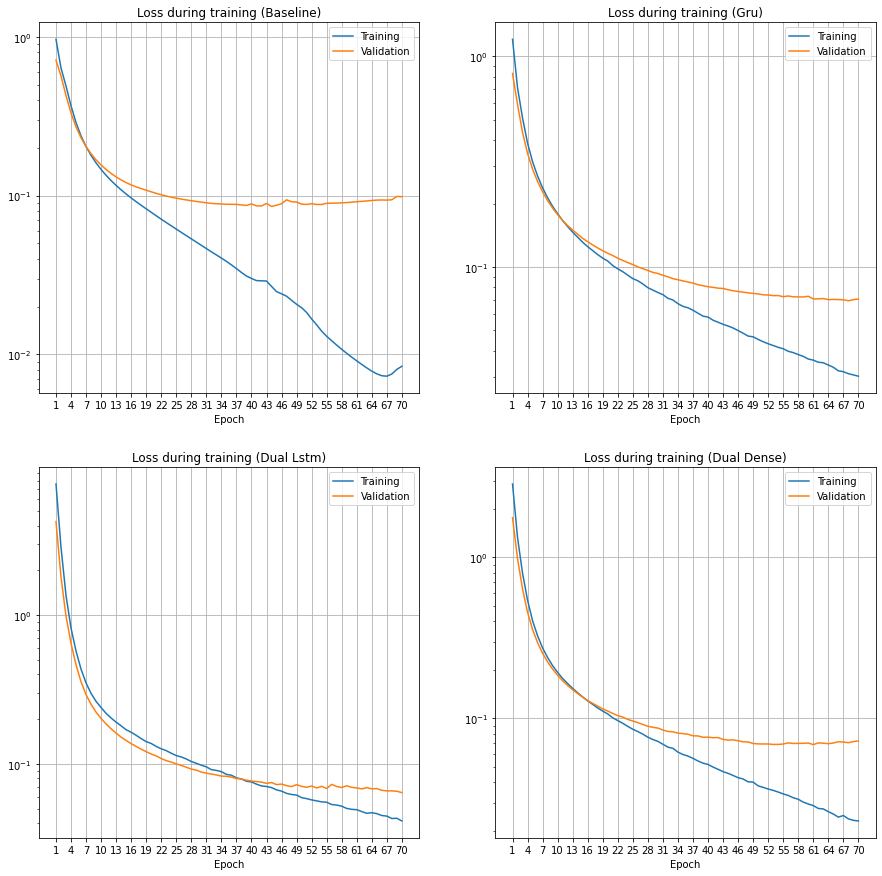

In [ ]:
def display_histories(histories: typing.Dict[str, keras.callbacks.History]):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    faxs = axs.ravel()

    for i, (name, history) in enumerate(histories.items()):
        train_loss = history.history["loss"]
        val_loss = history.history["val_loss"]

        # Visualize the behavior of the loss
        s_i = 0
        x_values = np.arange(1, len(train_loss)+1)[s_i:]
        faxs[i].plot(x_values, train_loss[s_i:])
        faxs[i].plot(x_values, val_loss[s_i:])
        faxs[i].set_xticks(np.arange(1, len(train_loss)+1, step=3))

        faxs[i].set_yscale("log")

        faxs[i].grid()
        faxs[i].set_title(f"Loss during training ({name.replace('_', ' ').title()})")
        faxs[i].set_xlabel("Epoch")
        faxs[i].legend(["Training", "Validation"])
    fig.show()


display_histories(histories)

The best weights are taken in the lowest value of validation loss for each model. In this case, it can be seen we're very close to the best-case scenario: regularized models have decreased their losses compared to the baseline model. The graphs allow us to determine that the networks have not overfitted and, instead, learned pretty well how to generalize.

It can be seen the Dual BiLSTM requires more epochs until the validation loss is higher than the tranining loss, this is due to heavier regularizations used.

## Dataframes for metrics

A Dataframe of each model predicted labels is created.

In [ ]:
def decode_true_labels(
    ds: tf.data.Dataset,
    decode_labels: DecodeLabels,
    punctuations: typing.Optional[str] = None,
):
    y_true = decode_labels(np.concatenate([y for _, y in ds], axis=0), predict=False)

    if punctuations is not None:
        df_idx = pd.DataFrame(y_true).apply(lambda x: ~x.str.fullmatch(punctuations))
        idx = df_idx.to_numpy().flatten()
        return y_true.flatten()[idx], idx
    return y_true.flatten(), None

In [ ]:
def create_models_dataframe(
    val_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
    models: typing.Dict[str, keras.Model],
    decode_labels: DecodeLabels,
    punctuations: typing.Optional[str] = None,
):
    n_models = len(models.keys())
    ds_dict = {"val": val_ds, "test": test_ds}

    df_dict = dict()
    df_dict["name"] = list(models.keys())

    for ds_name, ds in ds_dict.items():
        # Compute true labels for the dataset
        y_true, idx = decode_true_labels(ds, decode_labels, punctuations)

        # Add results to the dictionary later used to build the DataFrame
        df_dict[f"y_{ds_name}_true"] = np.repeat(
            y_true.reshape(1, -1), n_models, axis=0
        ).tolist()

        y_preds = np.zeros((n_models, y_true.size), dtype=object)
        for i, model in enumerate(models.values()):
            # computing predicted labels for the i-th model
            y_pred = decode_labels(model.predict(ds, verbose=2), predict=True).flatten()
            if idx is not None:
                y_pred = y_pred[idx]
            y_preds[i] = y_pred

        df_dict[f"y_{ds_name}_pred"] = y_preds.tolist()

    return pd.DataFrame.from_dict(df_dict, orient="columns")

In [ ]:
no_punct_path = os.path.join(os.getcwd(), "df_model_no_punct.pkl")
if os.path.exists(no_punct_path):
    df_no_punct = pd.read_pickle(no_punct_path)
else:
    trained_models = {
        "Baseline": baseline_model,
        "GRU": gru_model,
        "Dual LSTM": dual_lstm_model,
        "Dual Dense": dual_dense_model,
    }
    df_no_punct = create_models_dataframe(
        val_ds, test_ds, trained_models, decode_labels, data_loader.PUNCTUATIONS
    )
    df_no_punct.to_pickle(no_punct_path)

3/3 - 0s - 180ms/epoch - 60ms/step
3/3 - 0s - 160ms/epoch - 53ms/step
3/3 - 0s - 242ms/epoch - 81ms/step
3/3 - 1s - 830ms/epoch - 277ms/step
2/2 - 0s - 127ms/epoch - 64ms/step
2/2 - 0s - 117ms/epoch - 58ms/step
2/2 - 0s - 167ms/epoch - 84ms/step
2/2 - 0s - 128ms/epoch - 64ms/step


## Metrics

### Classification report

Checking whether the results on the test set are coherent with the results on the validation set.

In [ ]:
def compute_classification_report(y: pd.Series) -> pd.Series:
    print(f"Classification report for the {y['name']} model")
    print("VALIDATION")
    print(sklearn.metrics.classification_report(y["y_val_true"], y["y_val_pred"], zero_division=0))
    print(75 * "-")
    print("TEST")
    print(sklearn.metrics.classification_report(y["y_test_true"], y["y_test_pred"], zero_division=0))
    print(75 * "=")

    cp_val = sklearn.metrics.classification_report(
        y["y_val_true"], y["y_val_pred"], zero_division=0, output_dict=True
    )
    cp_test = sklearn.metrics.classification_report(
        y["y_test_true"], y["y_test_pred"], zero_division=0, output_dict=True
    )
    return pd.Series(
        data={
            "classification_report_val": cp_val,
            "classification_report_test": cp_test,
        }
    )


df_cr_no_punct = df_no_punct.apply(
    lambda x: compute_classification_report(x), axis=1
).rename(index=df_no_punct["name"])

assert isinstance(df_cr_no_punct, pd.DataFrame)

Classification report for the Baseline model
VALIDATION
              precision    recall  f1-score   support

                   1.00      1.00      1.00     93521
           #       0.00      0.00      0.00        15
           $       1.00      1.00      1.00       173
           ,       0.00      0.00      0.00         0
       -RRB-       0.00      0.00      0.00         0
           .       0.00      0.00      0.00         0
          CC       0.99      0.98      0.99       758
          CD       0.94      0.95      0.94      1249
          DT       0.99      0.99      0.99      2754
          EX       0.94      1.00      0.97        34
          FW       0.00      0.00      0.00         2
          IN       0.97      0.95      0.96      3275
          JJ       0.70      0.79      0.74      1924
         JJR       0.91      0.76      0.83       165
         JJS       0.90      0.78      0.83        58
          LS       0.00      0.00      0.00         3
          MD       0.98  

At first glance, it could look strange the fact that, even though we excluded the punctuation, some remnants of them can be found in the classification reports above. 

The reason is the following: punctuation has indeed been removed, however, we didn't prevent the model from predicting a punctuation tag (as this would require either changing the model or artificially manipulate the output of the network). Since the model can, sometimes, wrongfully predict a non-punctuation tag as punctuation tag, some rows related to them may occur in the classification report. 

We're sure, though, that the punctuation tags have been removed from the true labels because the support corresponding to punctuation tags is always 0.

From the dictionaries that we have obtained from the classification reports, we can determine that the models that have performed better in the validation set (in terms of macro avg f1-score) are the following:

In [ ]:
number_of_best = 2

model_names = df_no_punct['name']
model_names_idx = list(range(len(model_names)))
model_names_idx.sort(key=lambda i: df_cr_no_punct['classification_report_val'][i]['macro avg']['f1-score'], reverse=True) 

best_indices = model_names_idx[:number_of_best]

df_no_punct_best = df_no_punct.filter(items=best_indices, axis=0)
df_cr_no_punct_best =df_cr_no_punct.filter(items=[model_names[i] for i in best_indices], axis=0)

df_cr_no_punct_best['classification_report_val'].to_frame().apply(lambda x: x.map(lambda y: y['macro avg']['f1-score']))

,classification_report_val
Dual LSTM,0.761585
GRU,0.731463


Therefore, as requested, all the evaluations will be performed only on those two models ("Dual LSTM", "Dual Dense").

### Confusion matrix

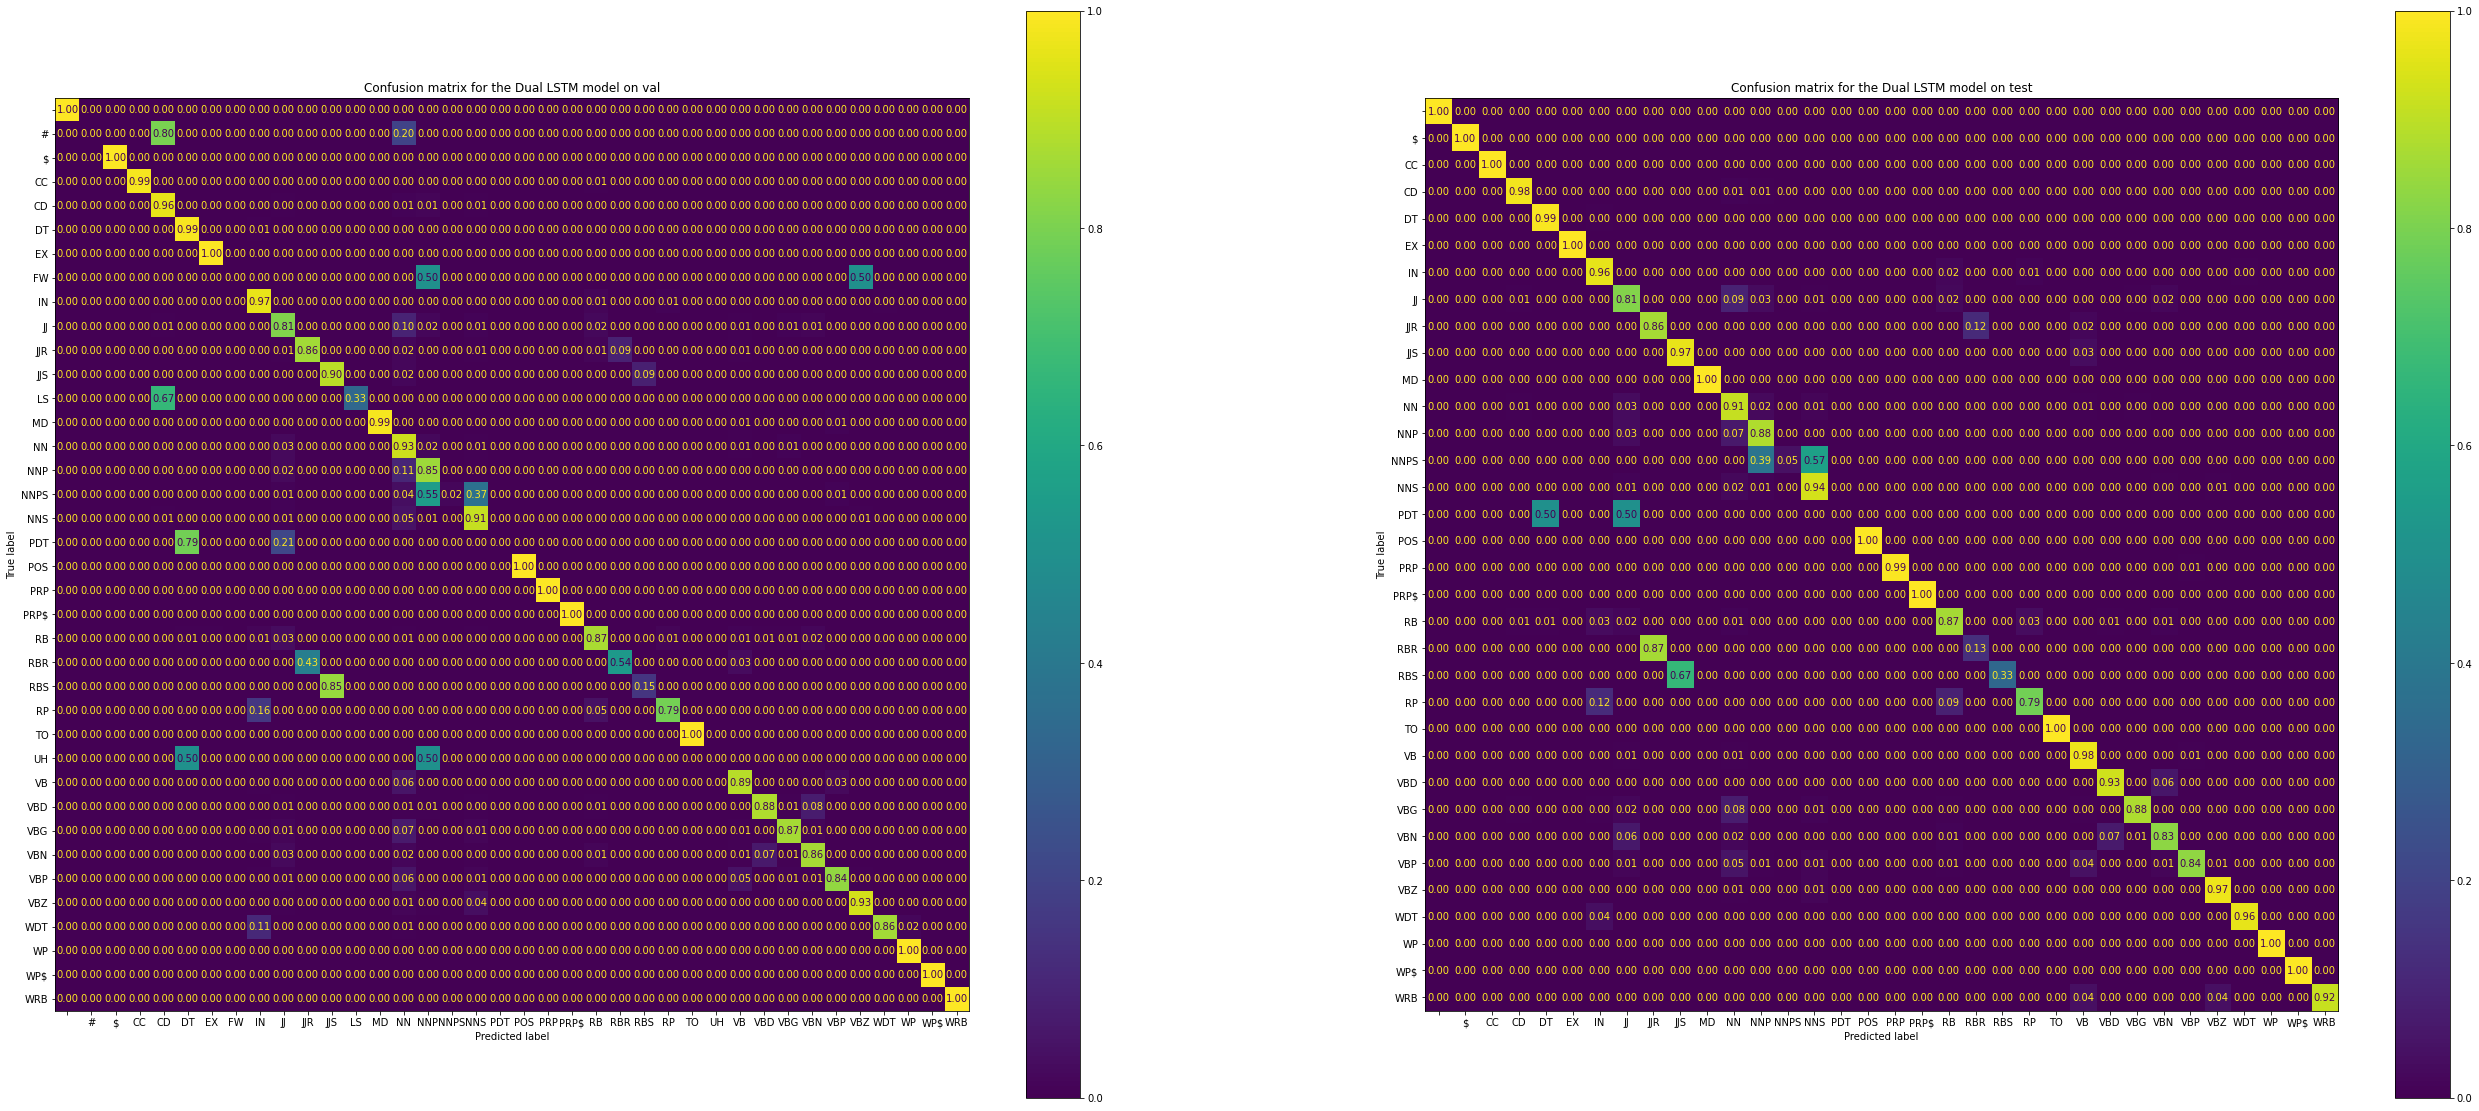

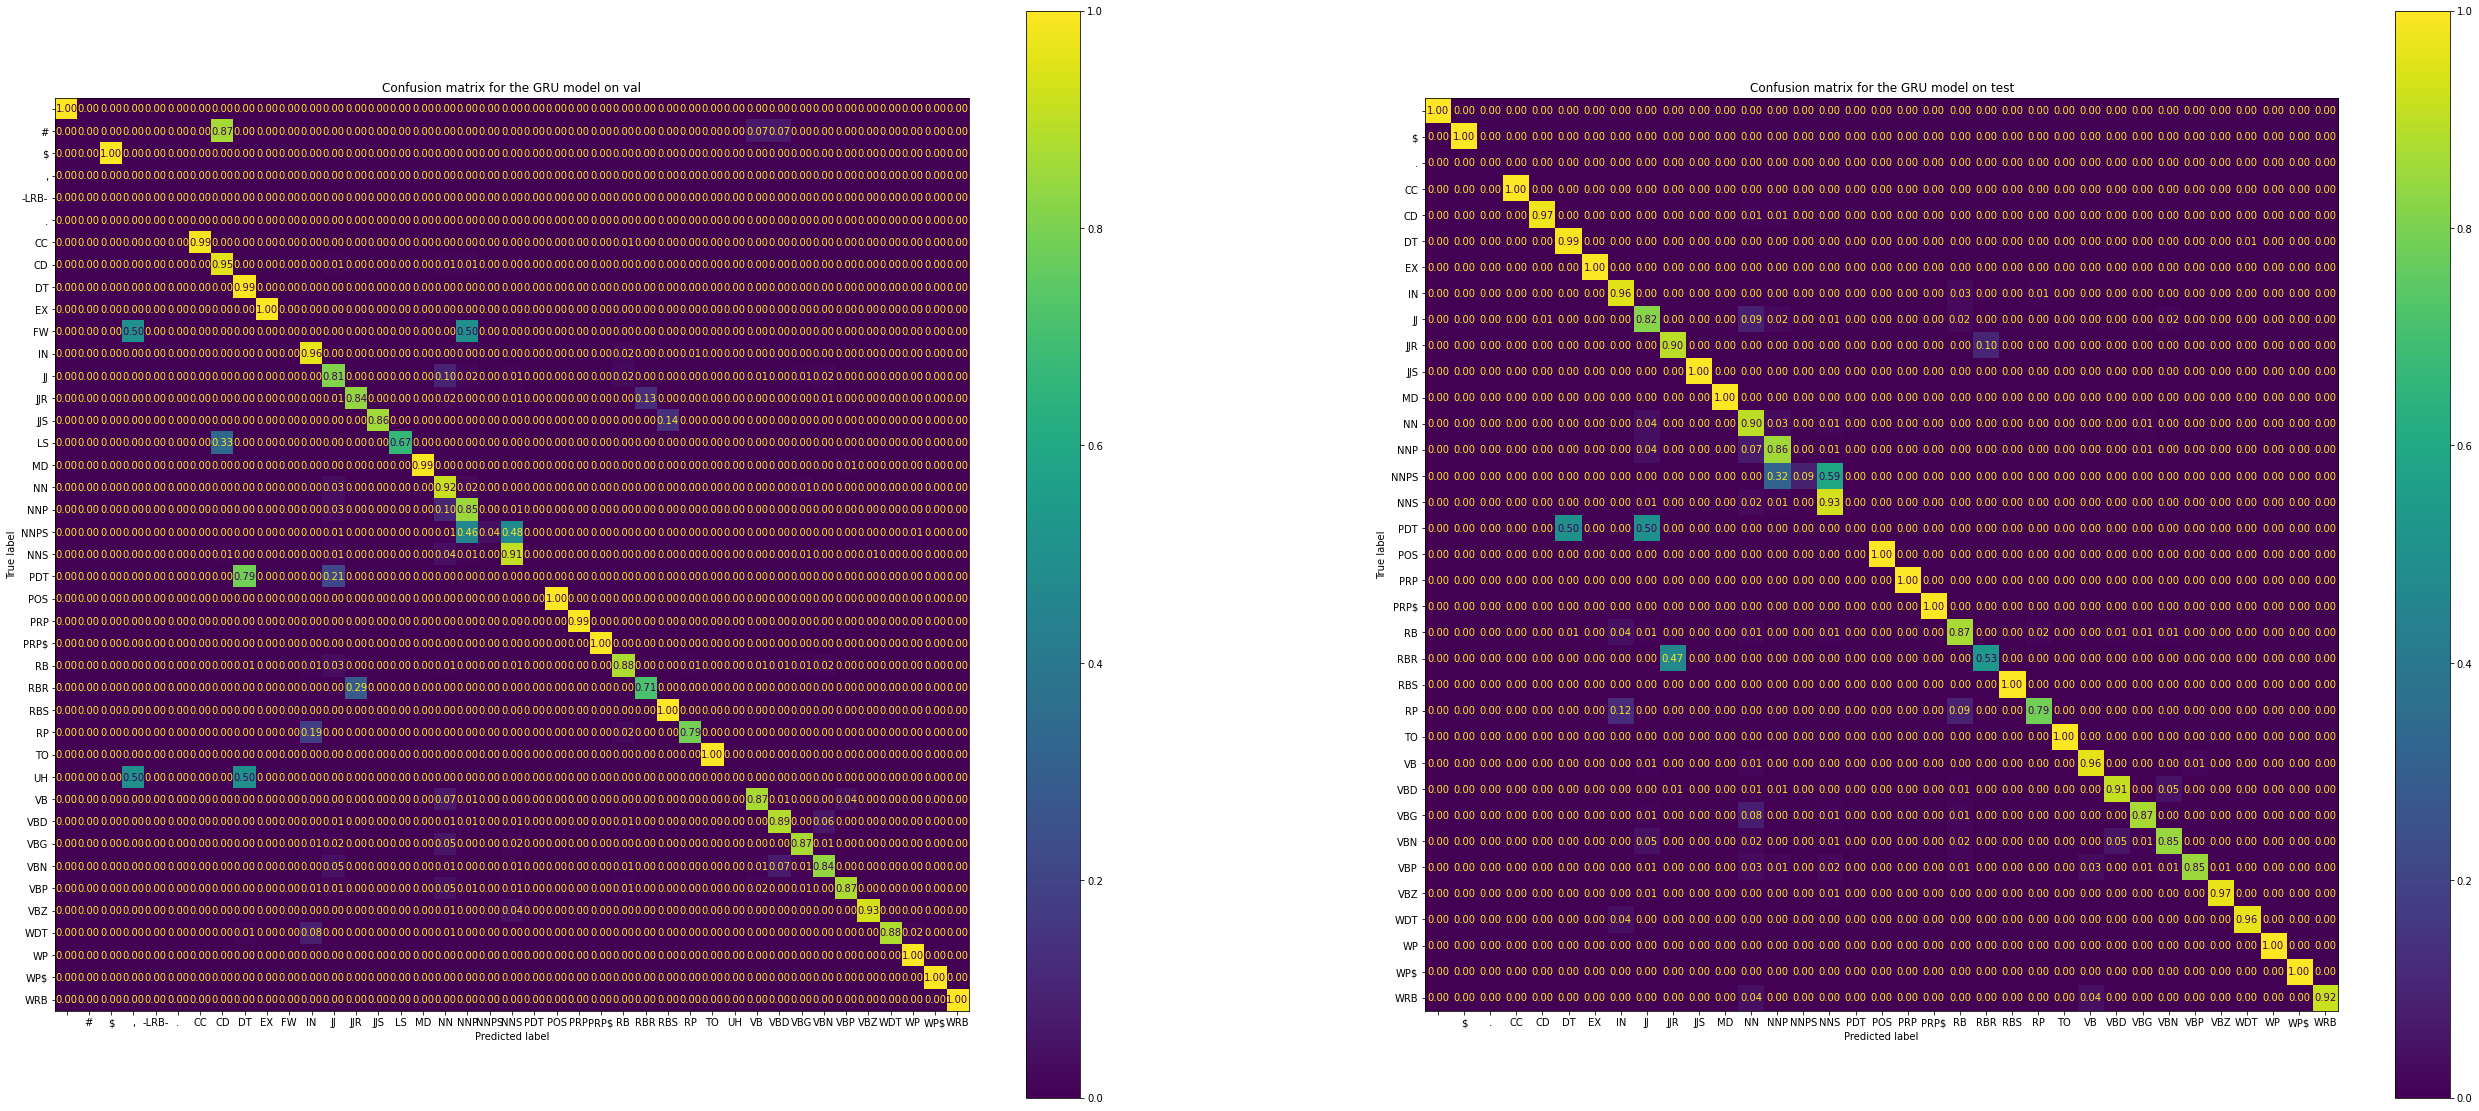

In [ ]:
def plot_confusion_matrix(y: pd.Series):
    fig, axs = plt.subplots(1, 2, figsize=(45, 20))
    faxs = axs.ravel()

    for i, column_name in enumerate(["val", "test"]):
        y_true = y[f"y_{column_name}_true"]
        y_pred = y[f"y_{column_name}_pred"]

        labels = np.unique(np.concatenate([y_true, y_pred]))
        disp = sklearn.metrics.ConfusionMatrixDisplay(
            sklearn.metrics.confusion_matrix(y_true, y_pred, normalize="true"),
            display_labels=labels,
        )
        disp.plot(ax=faxs[i], values_format=".2f")

        faxs[i].set_title(
            f"Confusion matrix for the {y['name']} model on {column_name}"
        )
    fig.show()


#_ = df_no_punct.apply(lambda x: plot_confusion_matrix(x), axis=1)
_ = df_no_punct_best.apply(lambda x: plot_confusion_matrix(x), axis=1)

### Histograms of macro averages of precision, recall and f1-score.

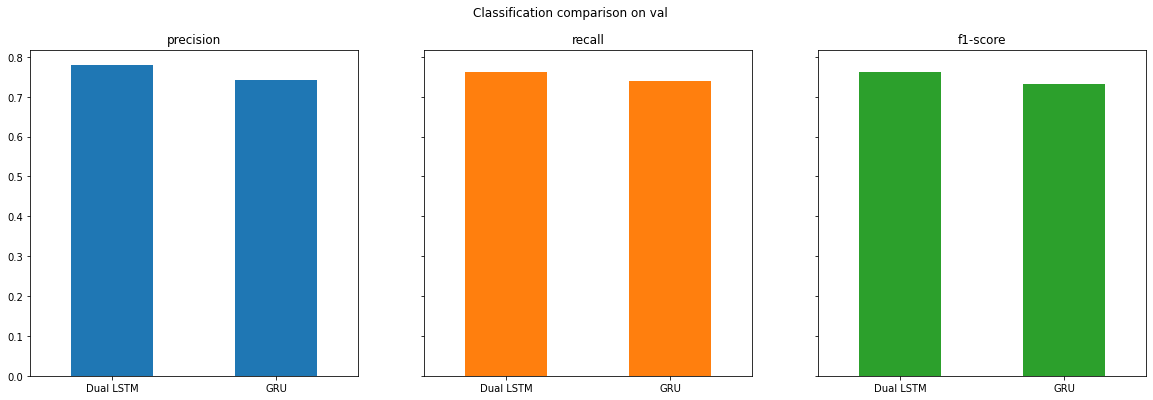

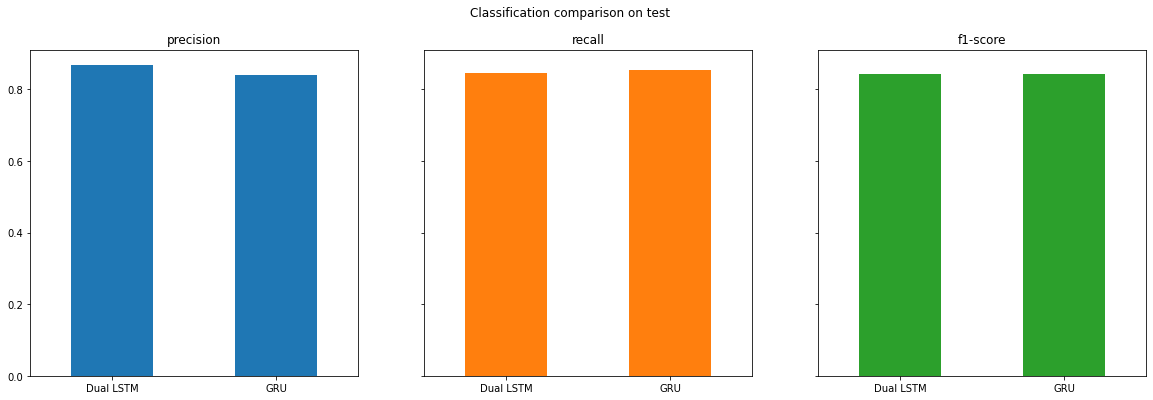

In [ ]:
def plot_histogram(df: pd.DataFrame, names: typing.List[str]):
    for name in names:
        df_histogram = df.apply(
            lambda x: pd.Series({**x[f"classification_report_{name}"]["macro avg"]}),
            axis=1,
        )

        df_histogram.plot.bar(
            y=["precision", "recall", "f1-score"],
            legend=False,
            subplots=True,
            sharey=True,
            layout=(1, 3),
            figsize=(20, 6),
            rot=0,
            xlabel="",
            title=f"Classification comparison on {name}",
        )


#plot_histogram(df_cr_no_punct, ["val", "test"])
plot_histogram(df_cr_no_punct_best, ["val", "test"])

Metrics that are usually computed like the R2, the MSE and the MAE are not useful in this situation: as a matter of fact, tags are assigned a number just for convenience purposes, but this does not mean that there is a "distance" between tags. 

The classic metrics like R2, MSE and MAE would implicitly assume that a distance between two tags can be computed, and that this would be equal to the absolute difference of the numerical representations of the tags, but this wouldn't make any sense. Suppose that a word should be classified with a tag $T$: the gravity of the error does not change if the word is misclassified with a tag $T' \neq T$, regardless of $T'$ and $T$.

### Bars of macro averages of precision, recall and f1-score among tags

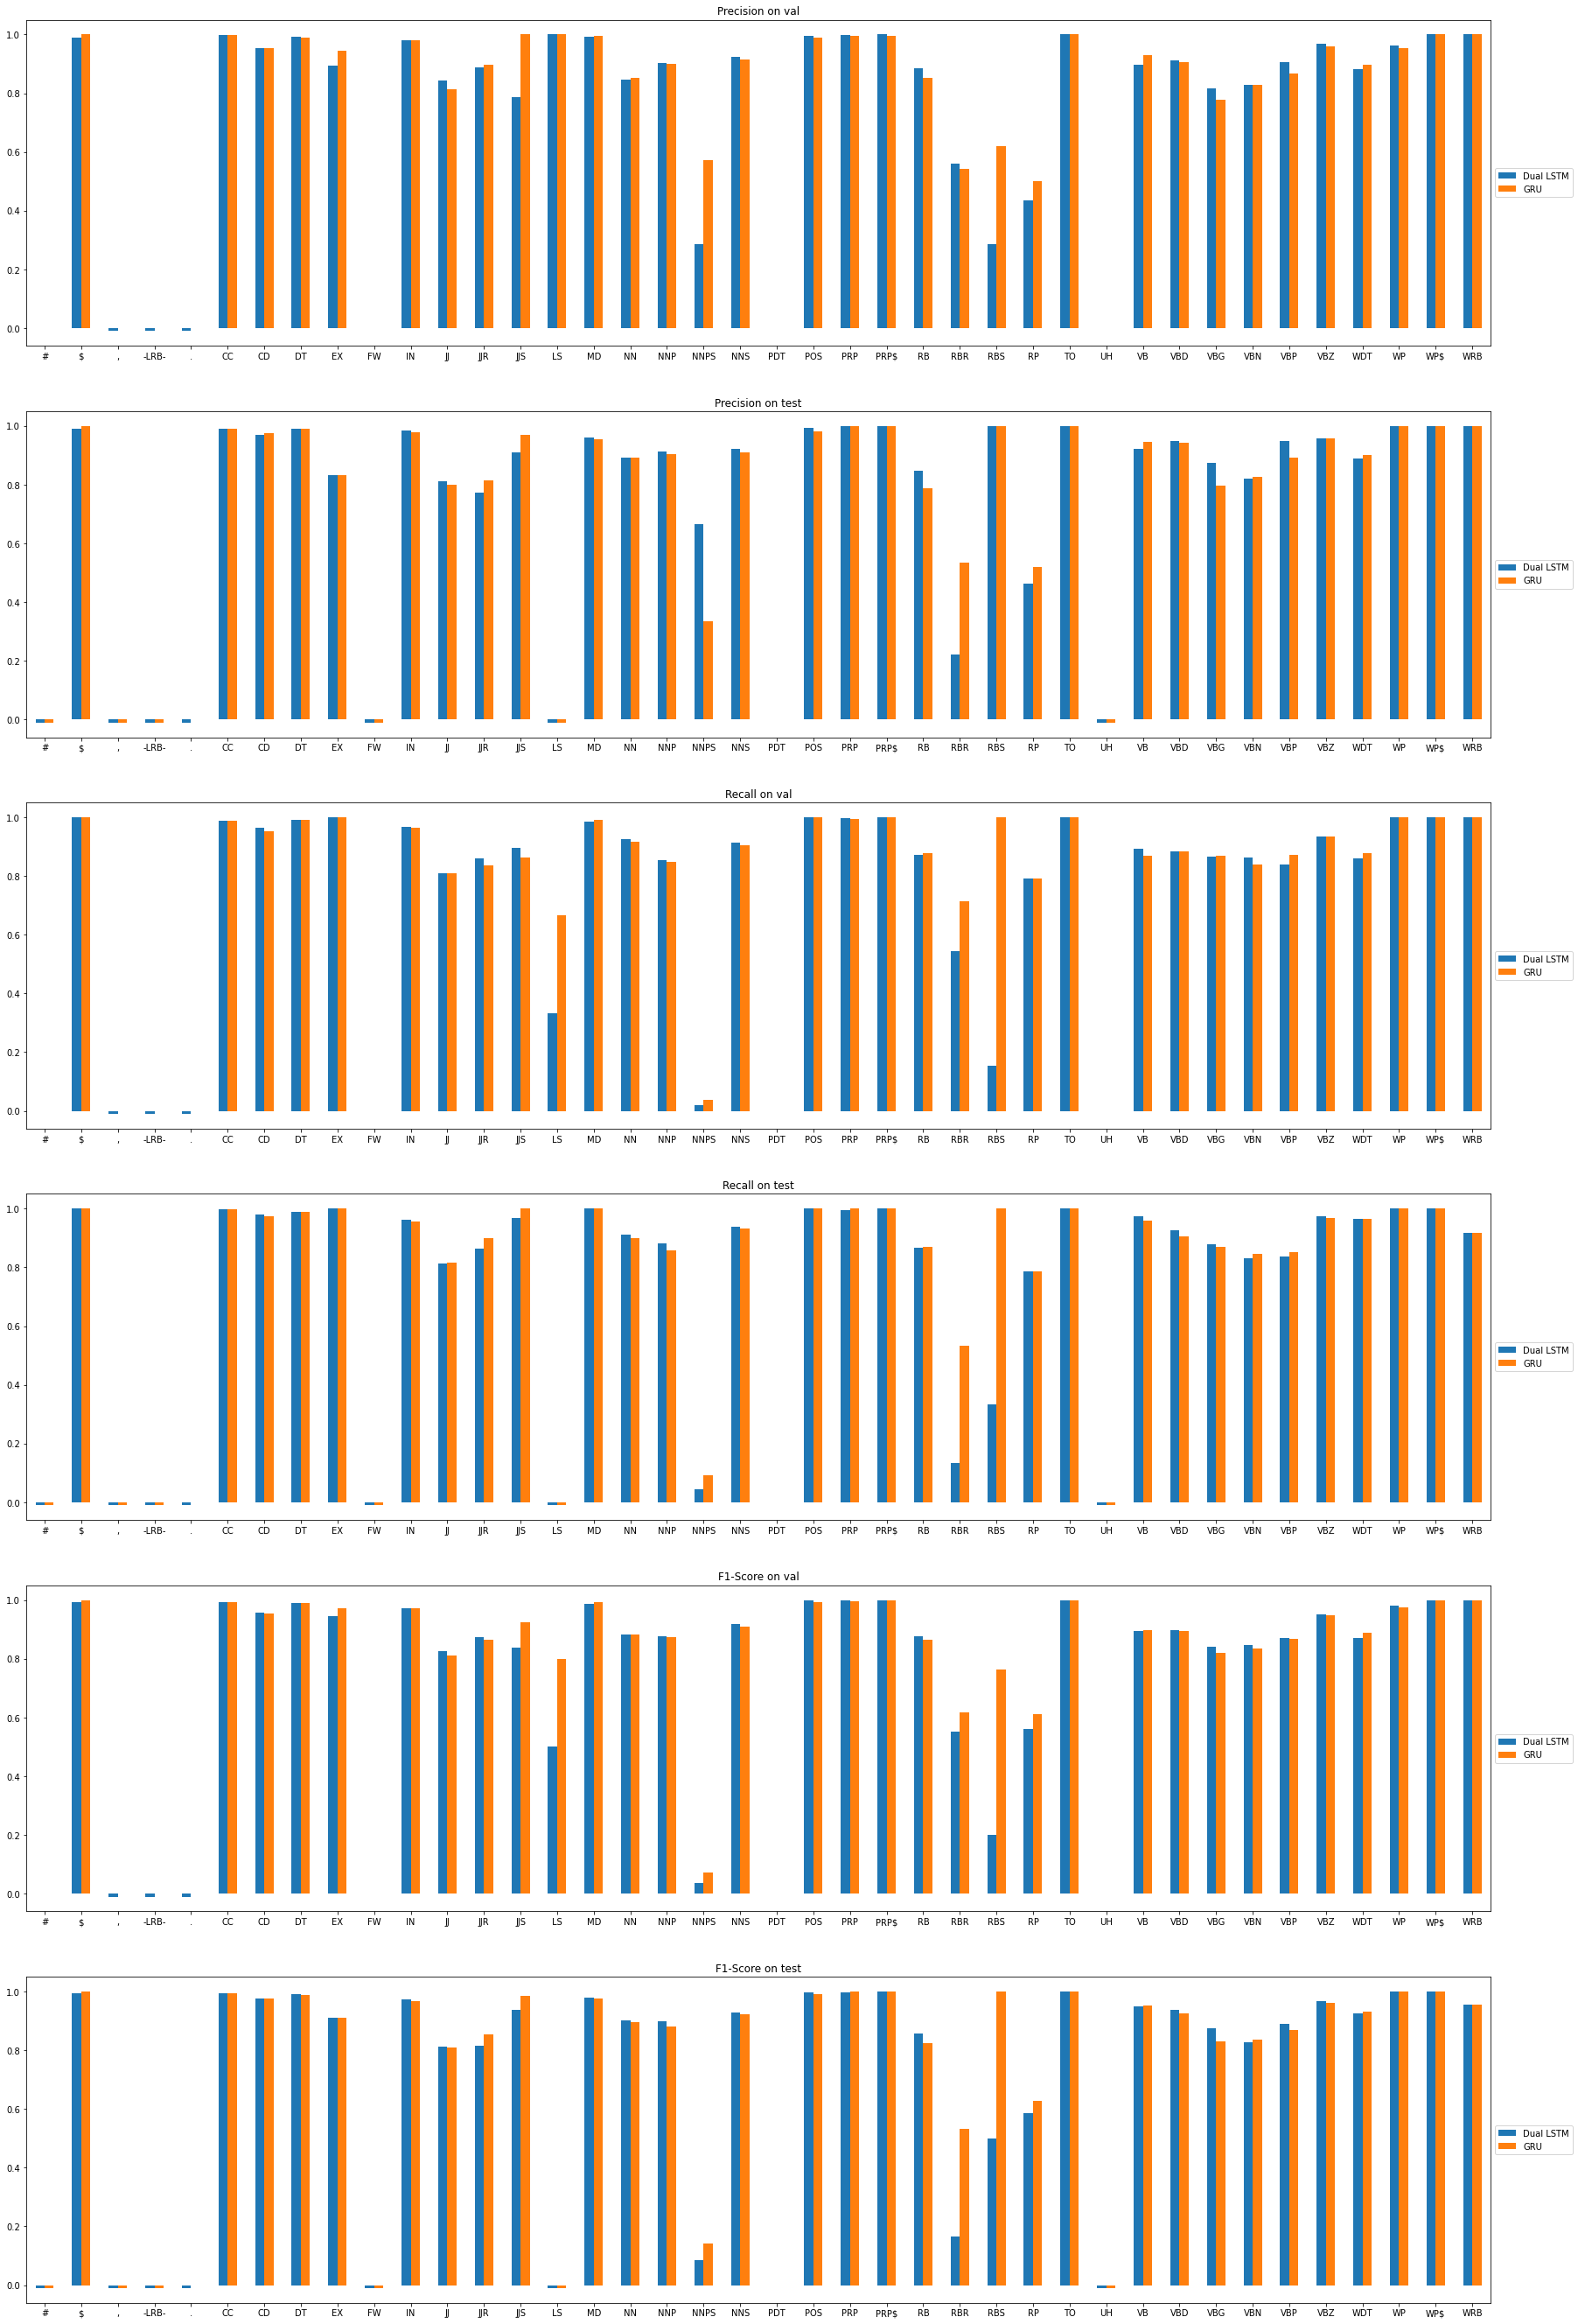

In [ ]:
def tags_transformation(ser: pd.Series, name: str, metric: str, all_tags: typing.Set[str]) -> pd.Series:
    drop_columns = ["", "accuracy", "macro avg", "weighted avg"]
    s = pd.Series({**ser[f"classification_report_{name}"]})
    s = s.reindex(sorted(all_tags), axis=1)
    return s.drop(drop_columns).map(lambda x: x[metric], na_action="ignore")


def plot_tags_histograms(df: pd.DataFrame, names: typing.List[str]):
    all_tags = set(df.applymap(lambda x: list(x.keys())).agg(np.concatenate).agg(np.concatenate))
    metrics = ["precision", "recall", "f1-score"]

    total_num = len(metrics) * len(names)
    fig, axs = plt.subplots(total_num, figsize=(30, 8 * total_num))
    faxs = axs.ravel()
    i = 0

    for metric in metrics:
        for name in names:
            df_tmp = df.apply(tags_transformation, axis=1, args=(name, metric, all_tags))
            df_tmp.fillna(-0.01, inplace=True)
            # df_tmp.rename(index=df["name"], inplace=True)

            df_t = df_tmp.transpose()    
            df_t.plot.bar(ax=faxs[i], title=f"{metric.title()} on {name}", legend={"reverse"}, rot=0)
            faxs[i].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

            i += 1

    fig.show()

#plot_tags_histograms(df_cr_no_punct, ["val", "test"])
plot_tags_histograms(df_cr_no_punct_best, ["val", "test"])

Small note: the "negative" scores are just symbolic, and are meant to distinguish tags for which a score does not exist from tags whose score is actually 0. This has been done since there is some small discrepancy between the set of predicted tags across models (for example, some predict sometimes the tag corresponding to ":" whereas some others do not at all).

## Error analysis

From the metrics, we can see that the results obtained in the validation set are coherent with the results on the test set. By "coherent", we mean that:

- Whenever a score (e.g. F1 score) is high for a single tag in the test set, the same holds for the same tag in the validation set (when the supports of the given tag are sufficiently close in both sets). This can be easily confirmed by looking at the classification reports.
- The classification capabilities of the models are very similar: we can quickly judge it by comparing the graphical representations of the confusion matrices generated from the performances of the models in the test set and in the validation set (whenever the supports of the given tag is sufficiently close in both sets, which can be seen again in the classification reports).

Since the results are coherent, we can just inspect the results obtained in the test set. We can observe in many ways that a lot of classes are correctly recognized most of the time. We want to inspect and hopefully give an explanation as for why some classes are not.

In [ ]:
def print_top_results(
    ser: pd.Series, n_tags: int, reverse = False
):
    name = "test"
    drop_columns = ["", "accuracy", "macro avg", "weighted avg"]
    metric = "f1-score"

    cp = {**ser[f"classification_report_{name}"]}
    metric_tags = [
        (k, round(v["f1-score"], 3)) for k, v in cp.items() if k not in drop_columns
    ]
    metric_tags.sort(key=lambda x: x[1], reverse=reverse)

    print(f"{ser.name}: {metric_tags[:n_tags]}")


print("---Worst classified tags---")
#_ = df_cr_no_punct.apply(print_top_results, axis=1, n_tags=10)
_ = df_cr_no_punct_best.apply(print_top_results, axis=1, n_tags=10)

print("\n\n---Best classified tags---")
#_ = df_cr_no_punct.apply(print_top_results, axis=1, n_tags=10, reverse=True)
_ = df_cr_no_punct_best.apply(print_top_results, axis=1, n_tags=10, reverse=True)

---Worst classified tags---
Dual LSTM: [('PDT', 0.0), ('NNPS', 0.085), ('RBR', 0.167), ('RBS', 0.5), ('RP', 0.584), ('JJ', 0.813), ('JJR', 0.816), ('VBN', 0.826), ('RB', 0.856), ('VBG', 0.876)]
GRU: [('.', 0.0), ('PDT', 0.0), ('NNPS', 0.143), ('RBR', 0.533), ('RP', 0.627), ('JJ', 0.808), ('RB', 0.825), ('VBG', 0.831), ('VBN', 0.837), ('JJR', 0.855)]


---Best classified tags---
Dual LSTM: [('PRP$', 1.0), ('TO', 1.0), ('WP', 1.0), ('WP$', 1.0), ('POS', 0.997), ('PRP', 0.997), ('$', 0.995), ('CC', 0.995), ('DT', 0.991), ('MD', 0.979)]
GRU: [('$', 1.0), ('PRP', 1.0), ('PRP$', 1.0), ('RBS', 1.0), ('TO', 1.0), ('WP', 1.0), ('WP$', 1.0), ('CC', 0.995), ('POS', 0.99), ('DT', 0.989)]


All models appear to behave very similarly even at the level of the tags. Many tags are classified either badly or well by all the models. 

Since the models have different architectures behind, it's reasonable to think that the reason lies before the model itself: the training set. 

We have plotted some histograms about the distribution of the classes. We can use those to look for an explanation as for why some tags are better classified than others. 

Let's compare for example the distribution of the tag "NNPS" (Proper noun, plural), badly classified by every model, and the tag "PRP\$" (Possessive pronoun), which is instead perfectly classified by all the models.

In [ ]:
tags_all.head()

,tags,train_counts,validation_counts,test_counts
0,#,1,15,0
1,$,342,173,209
2,'',399,225,70
3,",",2571,1528,787
4,-LRB-,52,50,18


In [ ]:
tag1 = "NNPS"
tag2 = "PRP$"

tags_all[(tags_all["tags"] == tag1) | (tags_all["tags"] == tag2)][["tags", "train_counts"]]

,tags,train_counts
21,NNPS,95
26,PRP$,409


On one hand, it certainly explains why all the models perform better in classifying the "PRP\$" tag rather than the "NNPS" tag, but this doesn't entirely capture the complexity of the situation. A hint is given by the fact that there are other tags with many more "examples" that, however, the model is not able to classify as well as "PRP\$". One such example is, trivially, the tag with the maximum number of examples:

In [ ]:
tags_all[tags_all["train_counts"] == tags_all["train_counts"].max()][
    ["tags", "train_counts"]
]

,tags,train_counts
19,NN,6270


### Noun, singular or mass

NN is the name of the tag used to classify the following: "Noun, singular or mass".

This could give another hint as for why this tag requires more effort in order to be recognized correctly, even though there are a lot more examples: there are a lot of possible names, whereas the number of possessive pronouns is very limited. 

Clearly, other factors may affect the assigned tag to a certain token: after all, the models are very complex and also take into account the tokens around (usually referred to as "context") and their order in both directions. 

Just to peek at the reason of this apparent discrepancy, rather than considering the total number of examples, we should evaluate the total number of unique examples that can be found both in the training set and in the test set out of the total number unique examples that can be found in the test set. 

A ratio close to 1 should correlate to good performances, and a small set of possible values should push the ratio towards 1 more easily.

In [ ]:
def restrict_words(ser: pd.Series, tag: str):
    text_s, text_t = ser["text"].split(" "), ser["tags"].split(" ")
    return np.array(text_s)[np.array(text_t) == tag]

def search_unique_words(df: pd.DataFrame, tag: str):
    return np.unique(df.apply(restrict_words, axis=1, tag=tag).agg(np.concatenate))

tag = "NN"
test_words = search_unique_words(df_test, tag)
train_words = search_unique_words(df_train, tag)
intersect_words = np.intersect1d(test_words, train_words, assume_unique=True)

print(f"Number of unique words tagged as '{tag}' in the test set: {test_words.size}")
print(f"Number of unique words tagged as '{tag}' in the training set: {train_words.size}")
print(f"Number of unique words tagged as '{tag}' can be found in both test set and train set: {intersect_words.size}")
print(f"Therefore, the ratio we're interested in is: {intersect_words.size/test_words.size:.2f}")

Number of unique words tagged as 'NN' in the test set: 818
Number of unique words tagged as 'NN' in the training set: 1805
Number of unique words tagged as 'NN' can be found in both test set and train set: 502
Therefore, the ratio we're interested in is: 0.61


But since the models are way more complex than that and are not limited to memorizing examples and tagging according to it, we can reasonably expect higher performances.

### Possessive pronouns

We can repeat the exact same procedure for the possessive pronouns:

In [ ]:
tag = "PRP$"
test_words = search_unique_words(df_test, tag)
train_words = search_unique_words(df_train, tag)
intersect_words = np.intersect1d(test_words, train_words, assume_unique=True)

print(f"Number of unique words tagged as '{tag}' in the test set: {test_words.size}")
print(f"Number of unique words tagged as '{tag}' in the training set: {train_words.size}")
print(f"Number of unique words tagged as '{tag}' can be found in both test set and train set: {intersect_words.size}")
print(f"Therefore, the ratio we're interested in is: {intersect_words.size/test_words.size:.2f}")

Number of unique words tagged as 'PRP$' in the test set: 8
Number of unique words tagged as 'PRP$' in the training set: 13
Number of unique words tagged as 'PRP$' can be found in both test set and train set: 8
Therefore, the ratio we're interested in is: 1.00


Which explains the discrepancy we've observed.

### Removing punctuation

Now, as an extra, we wanted to investigate in which way removing the punctuation influences the results. 

By following the same reasoning done to explain the discrepancy between class frequency and class labeling performances, we can conjecture that, by including the punctuation signs, the scores should improve (because we would now consider more tags that are very likely to be correctly identified). 

In order to confirm our suspicions, we just compute again the metrics that have been computed before, without removing the tags associated with punctuation beforehand.

In [ ]:
punct_path = os.path.join(os.getcwd(), "df_model_punct.pkl")
if os.path.exists(punct_path):
    df_punct = pd.read_pickle(punct_path)
else:
    trained_models = {
        "Baseline": baseline_model,
        "GRU": gru_model,
        "Dual LSTM": dual_lstm_model,
        "Dual Dense": dual_dense_model,
    }
    df_punct = create_models_dataframe(val_ds, test_ds, trained_models, decode_labels)
    df_punct.to_pickle(punct_path)

df_punct.head()

3/3 - 0s - 186ms/epoch - 62ms/step
3/3 - 0s - 178ms/epoch - 59ms/step
3/3 - 0s - 247ms/epoch - 82ms/step
3/3 - 0s - 169ms/epoch - 56ms/step
2/2 - 0s - 143ms/epoch - 72ms/step
2/2 - 0s - 133ms/epoch - 67ms/step
2/2 - 0s - 179ms/epoch - 90ms/step
2/2 - 0s - 141ms/epoch - 70ms/step


,name,y_val_true,y_val_pred,y_test_true,y_test_pred
0,Baseline,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, JJ, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJR...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."
1,GRU,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, JJ, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJR...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."
2,Dual LSTM,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, JJ, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJR...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."
3,Dual Dense,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, JJ, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJR...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."


In [ ]:
df_cr_punct = df_punct.apply(lambda x: compute_classification_report(x), axis=1).rename(index=df_punct["name"])

assert isinstance(df_cr_punct, pd.DataFrame)

Classification report for the Baseline model
VALIDATION
              precision    recall  f1-score   support

                   1.00      1.00      1.00     93521
           #       0.00      0.00      0.00        15
           $       1.00      1.00      1.00       173
          ''       1.00      1.00      1.00       225
           ,       1.00      1.00      1.00      1528
       -LRB-       1.00      0.96      0.98        50
       -RRB-       0.98      1.00      0.99        53
           .       1.00      1.00      1.00      1277
           :       1.00      0.98      0.99       214
          CC       0.99      0.98      0.99       758
          CD       0.94      0.95      0.94      1249
          DT       0.99      0.99      0.99      2754
          EX       0.94      1.00      0.97        34
          FW       0.00      0.00      0.00         2
          IN       0.97      0.95      0.96      3275
          JJ       0.70      0.79      0.74      1924
         JJR       0.91  

In [ ]:
def print_compare_metric(ser: pd.Series, metric: str):
    rename_fun = lambda x: (x, "_".join([metric] + x.rsplit("_", maxsplit=2)[-2:]))
    return ser.apply(lambda x: x['macro avg'][metric]).rename(dict(map(rename_fun, list(ser.index))))

# print_metric([df_cr_punct, ["val", "test"], "f1-score")
df_cr_punct.join(df_cr_no_punct, lsuffix="_punct", rsuffix="_nopunct").apply(print_compare_metric, axis=1, metric="f1-score").head()

,f1-score_val_punct,f1-score_test_punct,f1-score_val_nopunct,f1-score_test_nopunct
Baseline,0.769125,0.838254,0.674490,0.806157
GRU,0.821532,0.891245,0.731463,0.844052
Dual LSTM,0.798672,0.868884,0.761585,0.841890
Dual Dense,0.802089,0.863358,0.693889,0.835225
